# Plot RMSD

In [1]:
import pandas as pd
import pickle
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks")
sns.set_context("talk")

### Most recent data not processed, do so and add it

In [2]:
def get_rmsd_vals(filename):
    system = filename.split("_")[1].split("/")[1]
    if system == "denovo":
        system = "enh_opt"
    temperature = float(filename.split("_")[-2][:-1])
    replicate = int(filename.split("_")[-1].split(".")[0])
    with open(filename, "rb") as f:
        rmsd_array = pickle.load(f)
    rmsd_replicate = np.mean(rmsd_array[2,:])
    return {'system': system, 'temp': temperature, 'replicate': replicate, 'rmsd_avg': rmsd_replicate}

In [8]:
new_data = []
for root, dirs, files in os.walk("./rmsd_pkls/"):
    for filename in files:
        if filename.endswith(".pkl"):
            new_data.append(get_rmsd_vals(os.path.join(root, filename)))

In [9]:
new_data = pd.DataFrame(new_data)

In [10]:
new_data

,system,temp,replicate,rmsd_avg
0,enh,310.0,2,0.958624
1,enh,310.0,3,0.882052
2,enh,310.0,1,0.929628
3,enh,310.0,0,0.774325
4,enh,310.0,4,1.021657
...,...,...,...,...
115,uvf,298.0,4,2.388273
116,uvf,330.0,2,3.517426
117,uvf,330.0,0,3.025826
118,uvf,330.0,1,2.542232


In [11]:
combined_data = new_data[["system", "temp","rmsd_avg"]]

### Drop duplicates. hard because of slightly different floats
first round rmsd_avg

In [12]:
#round floats so that we can drop duplicates
combined_data['rmsd_avg'] = combined_data['rmsd_avg'].round(4)

/var/folders/9j/1f7mt18d2pqcwws6hwdx7_kr0000gn/T/ipykernel_56247/2507747744.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data['rmsd_avg'] = combined_data['rmsd_avg'].round(4)


In [13]:
combined_data = combined_data.drop_duplicates()

In [14]:
combined_data.groupby(['system', 'temp']).count()

rmsd_avg
system temp           
enh    298.0         5
       310.0         5
       320.0         5
       330.0         5
       340.0         5
       350.0         5
       360.0         5
       370.0         5
nomelt 298.0         5
       310.0         5
       320.0         5
       330.0         5
       340.0         5
       350.0         5
       360.0         5
       370.0         5
uvf    298.0         5
       310.0         5
       320.0         5
       330.0         5
       340.0         5
       350.0         5
       360.0         5
       370.0         5

In [15]:
df = combined_data.copy()

### Drop outlier points

In [16]:
# use iqlr to get the interquartile range
first_quartile = df.groupby(["system", "temp"])['rmsd_avg'].quantile(0.25)
third_quartile = df.groupby(["system", "temp"])['rmsd_avg'].quantile(0.75)

In [17]:
iql_factor = 1.5
def iql_filter(row):
    iql_range = third_quartile[row['system'], row['temp']] - first_quartile[row['system'], row['temp']]
    low = first_quartile[row['system'], row['temp']] - iql_factor * iql_range
    high = third_quartile[row['system'], row['temp']] + iql_factor * iql_range
    if row['rmsd_avg'] < low or row['rmsd_avg'] > high:
        return True
    else:
        return False

In [18]:
filter = df.apply(iql_filter, axis=1)
df = df[~filter]

In [19]:
filter.sum()

12

In [20]:
df

,system,temp,rmsd_avg
0,enh,310.0,0.9586
1,enh,310.0,0.8821
2,enh,310.0,0.9296
3,enh,310.0,0.7743
4,enh,310.0,1.0217
...,...,...,...
115,uvf,298.0,2.3883
116,uvf,330.0,3.5174
117,uvf,330.0,3.0258
118,uvf,330.0,2.5422


In [21]:
df.groupby(["system", "temp"]).count()

rmsd_avg
system temp           
enh    298.0         5
       310.0         5
       320.0         5
       330.0         5
       340.0         5
       350.0         5
       360.0         5
       370.0         4
nomelt 298.0         4
       310.0         5
       320.0         4
       330.0         5
       340.0         4
       350.0         4
       360.0         5
       370.0         5
uvf    298.0         4
       310.0         3
       320.0         4
       330.0         5
       340.0         5
       350.0         4
       360.0         4
       370.0         4

### normalize by 298K data

In [22]:
# find the average rmsd at 298k
rmsd_298 = df[df['temp'] == 298].groupby('system').mean()['rmsd_avg']
rmsd_298

system
enh       0.781260
nomelt    0.704175
uvf       2.533350
Name: rmsd_avg, dtype: float64

In [23]:
df['rmsd_avg'] = (df['rmsd_avg'] - rmsd_298[df['system']].values).astype(float)
df['temp'] = df['temp'].astype(float)

In [24]:
df

,system,temp,rmsd_avg
0,enh,310.0,0.17734
1,enh,310.0,0.10084
2,enh,310.0,0.14834
3,enh,310.0,-0.00696
4,enh,310.0,0.24044
...,...,...,...
115,uvf,298.0,-0.14505
116,uvf,330.0,0.98405
117,uvf,330.0,0.49245
118,uvf,330.0,0.00885


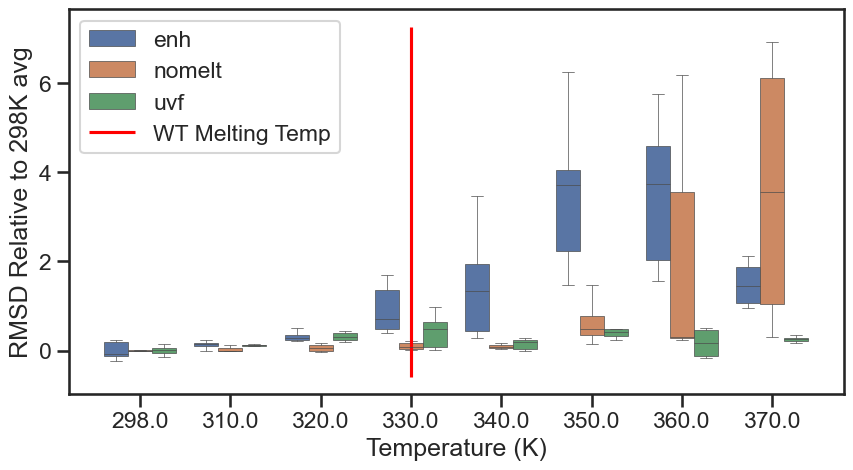

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df, x="temp", y="rmsd_avg", hue="system", whis=5, ax=ax, linewidth=0.5)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("RMSD Relative to 298K avg")
min, max = ax.get_ylim()
ax.vlines([3], min, max, color="red", label="WT Melting Temp")
ax.legend()
# plt.savefig("rmsd.png", dpi=300, bbox_inches="tight")

In [26]:
df['system'].unique()

array(['enh', 'nomelt', 'uvf'], dtype=object)

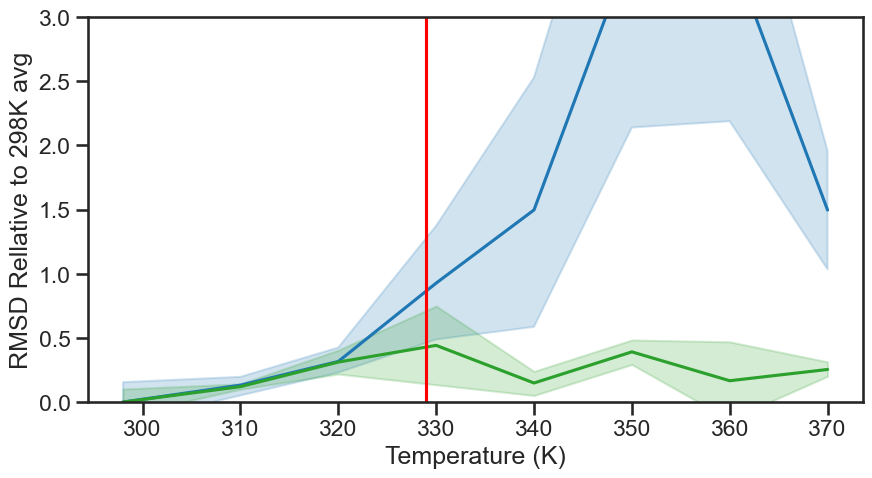

In [27]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=df[df['system']!='nomelt'], x="temp", y="rmsd_avg", hue="system", ax=ax, palette=['tab:blue', 'tab:green'])
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("RMSD Rellative to 298K avg")
ax.get_legend().remove()
ax.vlines([273+56], min, max, color="red", label="WT Melting Temp")
ax.set_ylim(0, 3.0)
plt.savefig("rmsd_defense_frame_1.png", dpi=300, bbox_inches="tight")

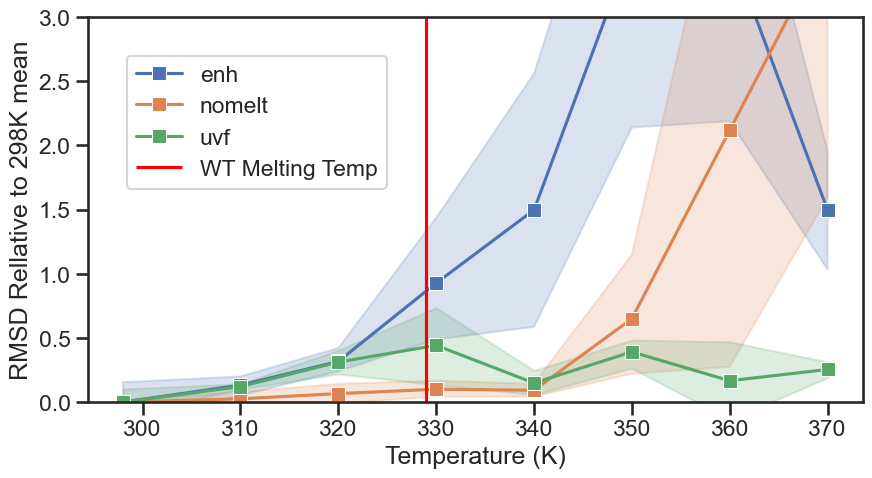

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))
# make sure to add markers along the lines for each point
sns.lineplot(data=df, x="temp", y="rmsd_avg", hue="system", ax=ax, marker='s', ms=10)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("RMSD Rellative to 298K mean")
# ax.get_legend().remove()
ax.vlines([273+56], min, max, color="red", label="WT Melting Temp")
plt.legend(bbox_to_anchor=(0.05, 0.9), loc=2, borderaxespad=0.)
ax.set_ylim(0, 3.0)
plt.savefig("rmsd_defense_frame_2.png", dpi=300, bbox_inches="tight")